In [1]:
x=1

In [45]:
import scanpy as sc
import scvi
import muon
import mudata as md
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [4]:
sc.set_figure_params(figsize=(4, 4))
torch.set_float32_matmul_precision("high")

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [39]:
rna = sc.read('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/multimil_reproducibility/pipeline/data/pp/pbmc_healthy_covid_rna_3cond_balanced.h5ad')
adt = sc.read('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/multimil_reproducibility/pipeline/data/pp/pbmc_healthy_covid_adt_3cond_balanced.h5ad')

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/scvi/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/scvi/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [40]:
rna.obsm['protein_expression'] = adt.layers['counts'].A.copy()
rna.X = rna.layers['counts'].A.copy()
rna

AnnData object with n_obs × n_vars = 365712 × 2000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4'
    var: 'feature_types', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'protein_expression'
    layers: 'counts'

In [41]:
scvi.model.TOTALVI.setup_anndata(
    rna, batch_key="patient_id", protein_expression_obsm_key="protein_expression"
)

INFO     Generating sequential column names                                                                        
INFO     Found batches with missing protein expression                                                             


In [42]:
model = scvi.model.TOTALVI(rna)

INFO     Computing empirical prior initialization for protein background.                                          


/tmp/ipykernel_2464153/2553505251.py:1: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  model = scvi.model.TOTALVI(rna)


In [43]:
model.train()

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/scvi/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /lustre/groups/ml01/workspace/anastasia.litinetsk ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/scvi/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /lustre/groups/ml01/workspace/anastasia.litinetsk ...
  rank_zero_w

Epoch 22/22: 100%|██████████| 22/22 [38:42<00:00, 104.45s/it, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.25e+3]

`Trainer.fit` stopped: `max_epochs=22` reached.


Epoch 22/22: 100%|██████████| 22/22 [38:42<00:00, 105.58s/it, v_num=1, train_loss_step=1.26e+3, train_loss_epoch=1.25e+3]


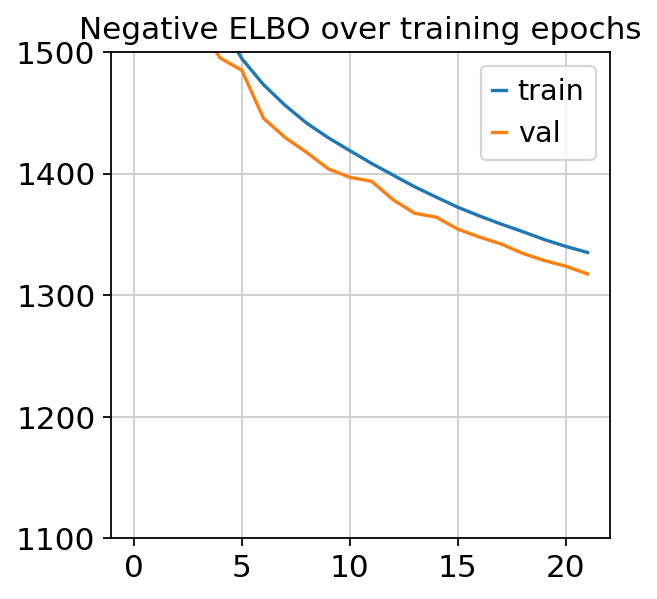

In [46]:
plt.plot(model.history["elbo_train"], label="train")
plt.plot(model.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

In [47]:
rna.obsm['X_totalVI'] = model.get_latent_representation()

In [48]:
rna.write('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/multimil_reproducibility/pipeline/data/pp/scvi_pbmc_healthy_covid.h5ad')

In [49]:
sc.pp.neighbors(rna, use_rep='X_totalVI')

In [50]:
sc.tl.umap(rna)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future vers

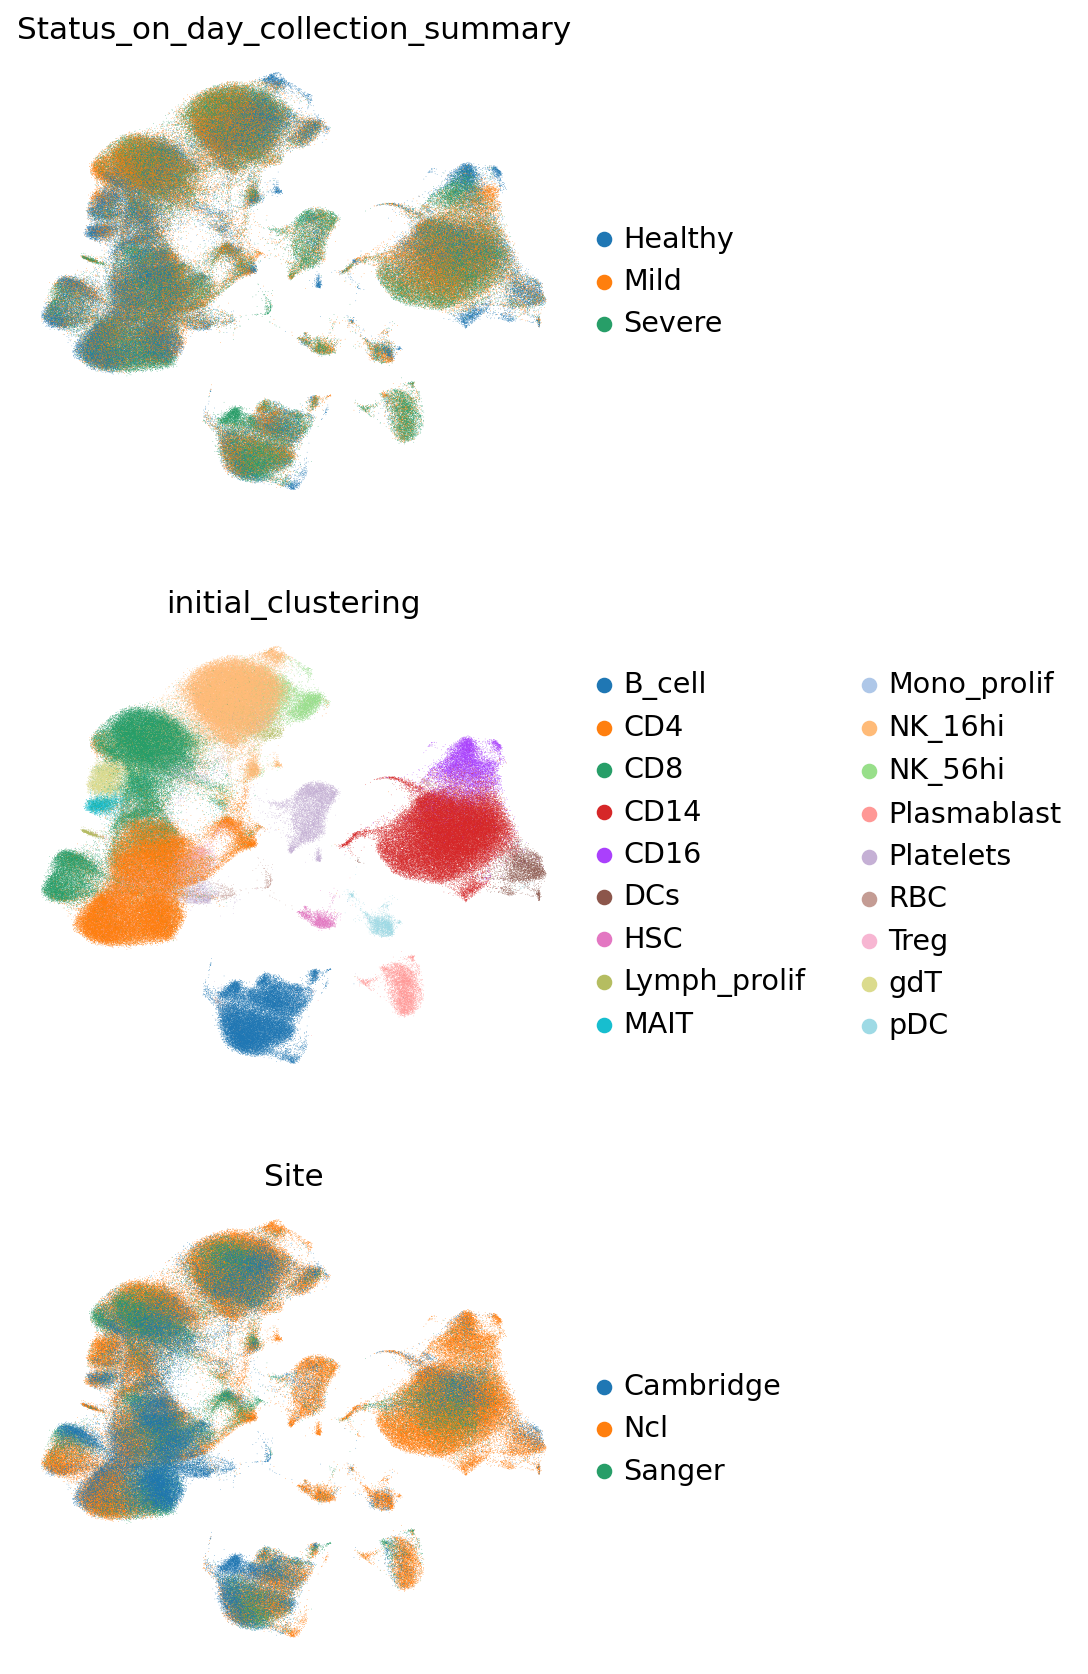

In [51]:
sc.pl.umap(rna, color=['Status_on_day_collection_summary', 'initial_clustering', 'Site'], frameon=False, ncols=1)

In [53]:
rna.obsm['X_totalVI'].shape

(365712, 20)

In [54]:
rna.write('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/multimil_reproducibility/pipeline/data/pp/scvi_pbmc_healthy_covid.h5ad')